In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCar-v0")

[2016-11-24 15:26:48,367] Making new env: MountainCar-v0


In [3]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100)),
        ("rbf5", RBFSampler(gamma=0.2, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None)), ('rbf5', RBFSampler(gamma=0.2, n_components=100, random_state=None))],
       transformer_weights=None)

### q: why is this RBF step needed? What would happen without it?

In [4]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, eta0=0.01, n_iter=5):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant", n_iter=n_iter, eta0=eta0)
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        # TODO: Implement this!
        action_values = []
        X = self.featurize_state(s).reshape(1, -1)
        for i in range(env.action_space.n):
            model = self.models[i]
            action_values.append(model.predict(X))
        if a == None:
            return action_values
        else:
            return action_values[a][0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        # TODO: Implement this!
        X = self.featurize_state(s)
        self.models[a].partial_fit([X], [y])       
        return None

In [5]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [6]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward), end="")
        sys.stdout.flush()
        
        # TODO: Implement this!
        
        # Reset env, get first action
        state = env.reset()
        action = np.random.choice(np.arange(env.action_space.n), p = policy(state))
        while True:            
            # Take one step
            next_state, reward, done, _ = env.step(action)
            
            # Update estimator
            next_action_values = np.array(estimator.predict(s=next_state))
            td_target = (reward + 
                        discount_factor * np.max(next_action_values))
            estimator.update(s=state, a=action, y=td_target)
            
            # Write stats
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] += 1
            
            # Break condition
            if done:
                break
                
            # Sample another action from epsilon-greedy(Q)
            policy = make_epsilon_greedy_policy(estimator, epsilon, env.action_space.n)
            next_action = np.random.choice(np.arange(env.action_space.n), p = policy(next_state))

            # Next step
            state = next_state
            action = next_action
                
        # Update epsilon. Use 1/k instead of geometric decay (which is not GLIE)
        epsilon = epsilon * (i_episode + 1) / (i_episode + 2)   
    
    return stats

In [13]:
def sarsa(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0,
         log_dir='/Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa/run1'):
    """
    SARSA algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    env.monitor.start(log_dir)
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward), end="")
        sys.stdout.flush()
        
        # TODO: Implement this!
        
        # Reset env, get first action
        state = env.reset()
        action = np.random.choice(np.arange(env.action_space.n), p = policy(state))
        while True:            
            # Take one step
            next_state, reward, done, _ = env.step(action)
            
            # Sample another action from epsilon-greedy(Q)
            policy = make_epsilon_greedy_policy(estimator, epsilon, env.action_space.n)
            next_action = np.random.choice(np.arange(env.action_space.n), p = policy(next_state))

            # Update estimator
            td_target = reward + discount_factor * estimator.predict(s=next_state, a=next_action)
            estimator.update(s=state, a=action, y=td_target)
            
            # Write stats
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] += 1
            
            # Break condition
            if done:
                break               

            # Next step
            state = next_state
            action = next_action
                
        # Update epsilon. Use 1/k instead of geometric decay (which is not GLIE)
        epsilon = epsilon * (i_episode + 1) / (i_episode + 2)   
    env.monitor.close()
    return stats

In [8]:
def sarsa_2(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0,
           log_dir='/Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa_2/run2'):

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))  
    
    # Record gym performance
    env.monitor.start(log_dir)
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward), end="")
        sys.stdout.flush()
        
        # TODO: Implement this!
        
        # Reset env, get first action
        state = env.reset()
        action = np.random.choice(np.arange(env.action_space.n), p = policy(state))
        
        while True:            
            # Take one step
            next_state, reward, done, _ = env.step(action)
            
            # Sample another action from epsilon-greedy(Q)
            policy = make_epsilon_greedy_policy(estimator, epsilon, env.action_space.n)
            next_action = np.random.choice(np.arange(env.action_space.n), p = policy(next_state))
            if done:
                break            
            next_next_state, next_reward, next_done, _ = env.step(next_action)
            next_next_action = np.random.choice(np.arange(env.action_space.n), p = policy(next_next_state))
            
            # Update estimator
            td_0 = reward + discount_factor * estimator.predict(s=next_state, a=next_action)
            td_1 = (reward + discount_factor * next_reward + 
                    np.power(discount_factor, 2) * 
                    estimator.predict(s=next_next_state, a=next_next_action))
            td_target = 0.5 * td_0 + 0.5 * td_1
            estimator.update(s=state, a=action, y=td_target)
                     
            # Write stats
            stats.episode_rewards[i_episode] += reward + discount_factor * next_reward
            stats.episode_lengths[i_episode] += 2
            
            # Break condition
            if next_done:
                break               

            # Next step
            state = next_next_state
            action = next_next_action
                
        # Update epsilon. Use 1/k instead of geometric decay (which is not GLIE)
        epsilon = epsilon * (i_episode + 1) / (i_episode + 2)   
    env.monitor.close()
    return stats

In [14]:
estimator = Estimator()

In [79]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats_q = q_learning(env, estimator, 50, epsilon=0)

Episode 50/50 (-117.0)

In [15]:
stats_sarsa = sarsa(env, estimator, 300, epsilon=0.1,
                   log_dir='/Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa/run1')

[2016-11-24 15:35:37,198] Creating monitor directory /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa/run1


Episode 1/300 (0.0)

[2016-11-24 15:35:37,201] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa/run1/openaigym.video.1.11685.video000000.mp4


Episode 2/300 (-200.0)

[2016-11-24 15:35:40,401] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa/run1/openaigym.video.1.11685.video000001.mp4


Episode 9/300 (-200.0)

[2016-11-24 15:35:45,677] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa/run1/openaigym.video.1.11685.video000008.mp4


Episode 28/300 (-167.0)

[2016-11-24 15:35:56,913] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa/run1/openaigym.video.1.11685.video000027.mp4


Episode 65/300 (-159.0)

[2016-11-24 15:36:12,863] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa/run1/openaigym.video.1.11685.video000064.mp4


Episode 126/300 (-149.0)

[2016-11-24 15:36:34,077] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa/run1/openaigym.video.1.11685.video000125.mp4


Episode 217/300 (-135.0)

[2016-11-24 15:37:03,970] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa/run1/openaigym.video.1.11685.video000216.mp4


Episode 300/300 (-137.0)

[2016-11-24 15:37:30,521] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa/run1')


In [10]:
stats_sarsa_2 = sarsa_2(env, estimator, 300, epsilon=0.0,
                       log_dir='/Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa_2/run2')

[2016-11-24 15:28:11,986] Creating monitor directory /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa_2/run2


Episode 1/300 (0.0)

[2016-11-24 15:28:11,988] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa_2/run2/openaigym.video.0.11685.video000000.mp4


Episode 2/300 (-100.0)

[2016-11-24 15:28:15,955] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa_2/run2/openaigym.video.0.11685.video000001.mp4


Episode 9/300 (-100.0)

[2016-11-24 15:28:21,884] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa_2/run2/openaigym.video.0.11685.video000008.mp4


Episode 28/300 (-100.0)

[2016-11-24 15:28:32,514] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa_2/run2/openaigym.video.0.11685.video000027.mp4


Episode 65/300 (-100.0)

[2016-11-24 15:28:48,873] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa_2/run2/openaigym.video.0.11685.video000064.mp4


Episode 126/300 (-75.0)

[2016-11-24 15:29:12,421] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa_2/run2/openaigym.video.0.11685.video000125.mp4


Episode 217/300 (-57.0)

[2016-11-24 15:29:41,464] Starting new video recorder writing to /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa_2/run2/openaigym.video.0.11685.video000216.mp4


Episode 300/300 (-68.0)

[2016-11-24 15:30:05,245] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa_2/run2')


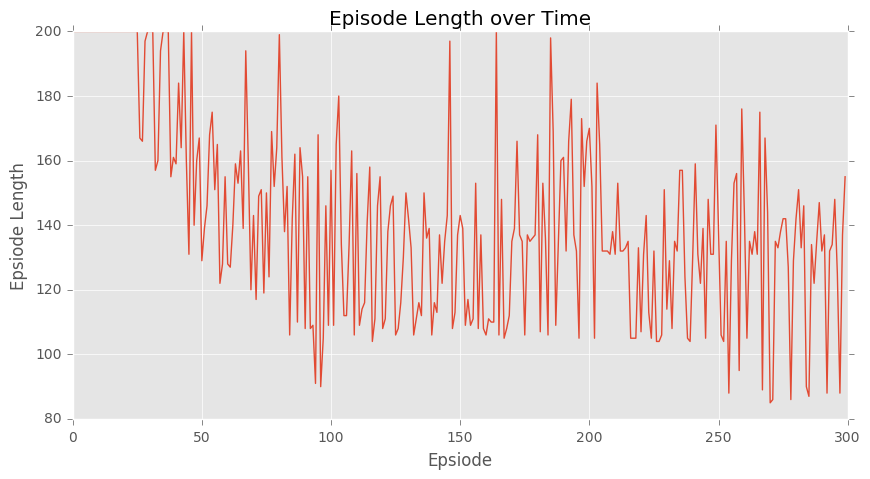

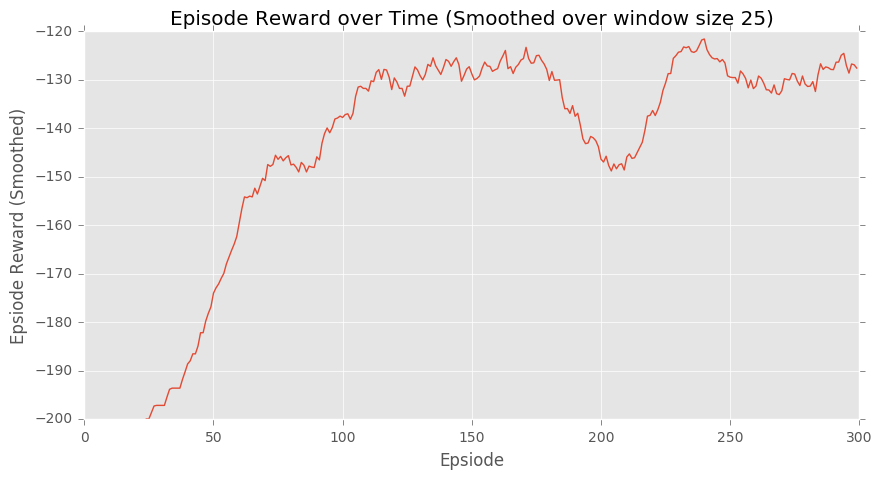

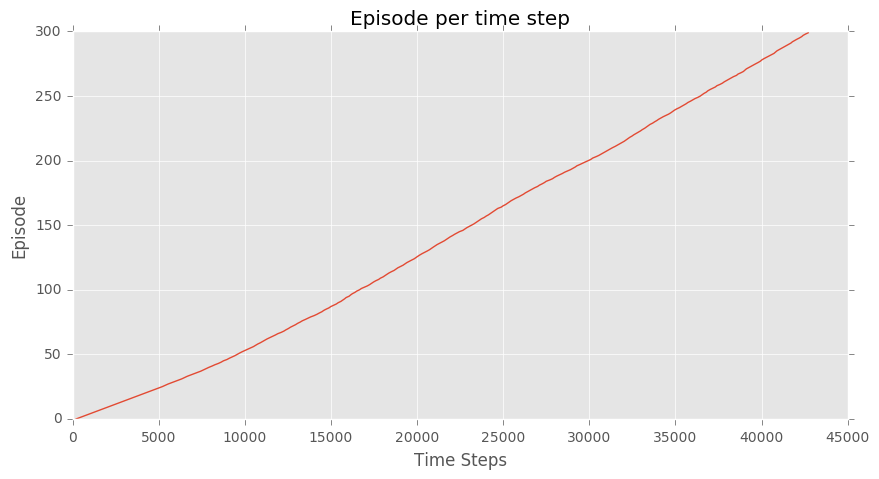

(<matplotlib.figure.Figure at 0x11d07f198>,
 <matplotlib.figure.Figure at 0x11d626828>)

In [17]:
# plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats_sarsa, smoothing_window=25)

#### Upload results to gym

In [16]:
gym.upload('/Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa/run1',
          api_key='sk_JYEAUzXOTM6DWzeHwOA3kg')

[2016-11-24 15:38:16,572] [MountainCar-v0] Uploading 300 episodes of training data
[2016-11-24 15:38:18,424] [MountainCar-v0] Uploading videos of 7 training episodes (246575 bytes)
[2016-11-24 15:38:19,824] [MountainCar-v0] Creating evaluation object from /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa/run1 with learning curve and training video
[2016-11-24 15:38:20,130] 
****************************************************
You successfully uploaded your evaluation on MountainCar-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_92goXfkfQ92vuPsuSBHRbw

****************************************************


In [12]:
gym.upload('/Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa_2/run2', 
           api_key='sk_JYEAUzXOTM6DWzeHwOA3kg')

[2016-11-24 15:31:47,631] [MountainCar-v0] Uploading 300 episodes of training data
[2016-11-24 15:31:50,443] [MountainCar-v0] Uploading videos of 7 training episodes (270329 bytes)
[2016-11-24 15:31:51,696] [MountainCar-v0] Creating evaluation object from /Users/tongwang/Playground/reinforcement-learning-exercises/Recordings/MountainCar/sarsa_2/run2 with learning curve and training video
[2016-11-24 15:31:51,987] 
****************************************************
You successfully uploaded your evaluation on MountainCar-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_I5v4PSBQNqdPOoV7eyGzg

****************************************************


### Discussion

Observations: performance peaked at around 60 episodes, and then started to decline. Why? Is it too high learing rate? Too unstable updates?

Try a few things:
* Default: -111
* n_iter = 1: not much difference
* eta0 = 0.005: not much difference

To do next:
* Implement in Sarsa and compare
    * -> Not much difference, performance still declines after ~60 episodes
* Implement in Sarsa(lambda) and compare
* Understand RBS basis. Try some other basis?
* Try fixed Q-targets? (batch method)
* Watch Rich tutorial and maybe understand how to tune this thing

__Sarsa(2)/TD(2) does much better. However the performance also fell off a cliff after too much training. Why is this? -> No better, just counting error...__

__#q: how to do sarsa(lambda) on a continous state space?__